# Intro to Gradient Boosting
- **Student** Michael McCann
- **Date** 15 MAR 2022

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

In [4]:
census_filepath = ('/content/drive/MyDrive/Data/census_income.csv')
df = pd.read_csv(census_filepath, index_col = 'Unnamed: 0')

display(df.head())
print('\n')
df.info()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K




<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital-status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital-gain    32561 non-null  int64 
 9   capital-loss    32561 non-null  int64 
 10  hours-per-week  32561 non-null  int64 
 11  native-country  32561 non-null  object
 12  income-class    32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.5+ MB


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

In [5]:
## NA's 
df.isna().sum().sum()

0

In [6]:
## dupes
df.duplicated().sum().sum()

3465

In [7]:
for i in df.columns:
    print('\n\n', i, '\n',  df[i].sort_values().unique())



 age 
 [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]


 workclass 
 ['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay']


 education 
 ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']


 marital-status 
 ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']


 occupation 
 ['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']


 relationship 
 ['Husband' 'Not-in-family' 'Other-re

In [8]:
df[df['workclass'] == '?']

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
27,54,?,Some-college,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,7th-8th,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,Some-college,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,10th,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,10th,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,?,Bachelors,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32531,30,?,Bachelors,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32539,71,?,Doctorate,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32541,41,?,HS-grad,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [9]:
## Eliminate the ? entries in occupation and native country as those are unhelpful results.
df.drop(df[df['occupation'] == '?'].index, inplace = True)
df.drop(df[df['native-country'] == '?'].index, inplace = True)

In [10]:
#Check data distribution (uneven 22.5k under 50k, 7.5k over)
df['income-class'].value_counts()

<=50K    22654
>50K      7508
Name: income-class, dtype: int64

In [11]:
#recode income class
df['income-class'] = df['income-class'].map({'<=50K': 0, '>50K': 1})

In [12]:
X = df.drop(columns = 'income-class')
y = df['income-class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
num_sel = make_column_selector(dtype_include = 'number')
cat_sel = make_column_selector(dtype_include = 'object')

In [14]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

processor = make_column_transformer((scaler, num_sel),
                                    (ohe , cat_sel),
                                    remainder = 'passthrough')

In [15]:
# processor.fit(X_train, y_train)
# pd.DataFrame(processor.transform(X_train)).info()

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [16]:
%%time
xgb = XGBClassifier()
xgb_pipe = make_pipeline(processor, xgb)
xgb_pipe.fit(X_train, y_train)

CPU times: user 5.25 s, sys: 74.9 ms, total: 5.32 s
Wall time: 5.4 s


In [17]:
print(f'XGB Training Score {xgb_pipe.score(X_train, y_train)}')
print(f'XGB Test Score {xgb_pipe.score(X_test, y_test)}')

print('\n\nXGB Training Classification Report')
print(classification_report(y_train, xgb_pipe.predict(X_train)))

print('\n\nXGB Test Classification Report')
print(classification_report(y_test, xgb_pipe.predict(X_test)))

XGB Training Score 0.858450112727112
XGB Test Score 0.864739424479512


XGB Training Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     16992
           1       0.79      0.58      0.67      5629

    accuracy                           0.86     22621
   macro avg       0.83      0.77      0.79     22621
weighted avg       0.85      0.86      0.85     22621



XGB Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      5662
           1       0.82      0.59      0.68      1879

    accuracy                           0.86      7541
   macro avg       0.85      0.77      0.80      7541
weighted avg       0.86      0.86      0.86      7541



Which target class is your model better at predicting?  Is it significantly overfit?
- The model does not appear to be overfit
- better at predicting the Under 50K 

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [18]:
%%time
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(processor, lgbm)
lgbm_pipe.fit(X_train, y_train)

CPU times: user 514 ms, sys: 0 ns, total: 514 ms
Wall time: 530 ms


In [19]:
print(f'LGBM Training Score {lgbm_pipe.score(X_train, y_train)}')
print(f'LGB Test Score {lgbm_pipe.score(X_test, y_test)}')

print('\n\nLGBM Training Classification Report')
print(classification_report(y_train, lgbm_pipe.predict(X_train)))

print('\n\nLGBM Test Classification Report')
print(classification_report(y_test, lgbm_pipe.predict(X_test)))

LGBM Training Score 0.8831174572300076
LGB Test Score 0.8756133138841002


LGBM Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     16992
           1       0.81      0.70      0.75      5629

    accuracy                           0.88     22621
   macro avg       0.86      0.82      0.84     22621
weighted avg       0.88      0.88      0.88     22621



LGBM Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5662
           1       0.80      0.67      0.73      1879

    accuracy                           0.88      7541
   macro avg       0.85      0.81      0.82      7541
weighted avg       0.87      0.88      0.87      7541



## GradientBoostingClassifier

In [20]:
%%time
gbc = GradientBoostingClassifier()
gbc_pipe = make_pipeline(processor, gbc)
gbc_pipe.fit(X_train, y_train)

CPU times: user 6.54 s, sys: 0 ns, total: 6.54 s
Wall time: 6.52 s


In [21]:
print(f'GBC Training Score {gbc_pipe.score(X_train, y_train)}')
print(f'GBC Test Score {gbc_pipe.score(X_test, y_test)}')

print('\n\nGBC Training Classification Report')
print(classification_report(y_train, gbc_pipe.predict(X_train)))

print('\n\nGBC Test Classification Report')
print(classification_report(y_test, gbc_pipe.predict(X_test)))

GBC Training Score 0.8622960965474559
GBC Test Score 0.8676568094417186


GBC Training Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     16992
           1       0.80      0.59      0.68      5629

    accuracy                           0.86     22621
   macro avg       0.84      0.77      0.80     22621
weighted avg       0.86      0.86      0.85     22621



GBC Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5662
           1       0.82      0.60      0.69      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.78      0.80      7541
weighted avg       0.86      0.87      0.86      7541




# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [22]:
xgb_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfe5901c50>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfe5901bd0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [23]:
params = {'xgbclassifier__n_estimators': [100, 250, 500],
          'xgbclassifier__max_depth': range(1,5), 
          'xgbclassifier__learning_rate': [0.1, 0.05, 0.15] }

In [24]:
%%time
xgb_grid = GridSearchCV(xgb_pipe, params)
xgb_grid.fit(X_train, y_train)

CPU times: user 30min 21s, sys: 2.79 s, total: 30min 23s
Wall time: 30min 15s


In [25]:
xgb_grid.best_params_

{'xgbclassifier__learning_rate': 0.15,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__n_estimators': 500}

In [26]:
best_xgb = xgb_grid.best_estimator_

# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

In [29]:
print(classification_report(y_test, best_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5662
           1       0.80      0.67      0.73      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.81      0.82      7541
weighted avg       0.87      0.87      0.87      7541



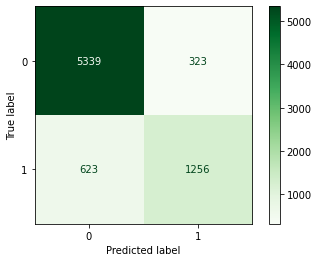

In [28]:
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap = 'Greens')

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

